In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# LSTM
An LSTM has a similar control flow as a recurrent neural network. It processes data passing on information as it propagates forward. The differences are the operations within the LSTM’s cells.

**Pipeline**
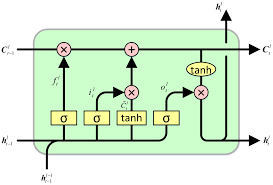

In [ ]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import string

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
#Implementing Embedding layer 
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [ ]:
train.describe

EDA

In [ ]:
train["target"].value_counts()

In [ ]:
#Area Under Curve
def roc_auc(predictions,target):
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
#Training and testing of data
x_train, x_te, y_train, y_te = train_test_split(train.text.values, train.target.values, 
                                                  stratify=train.target.values, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [ ]:
#Main part of pad sequence for training and testin data
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 200

token.fit_on_texts(list(x_train) + list(x_te))
x_train_seq = token.texts_to_sequences(x_train)
x_te_seq = token.texts_to_sequences(x_te)

#zero pad the sequences
x_train_pad = sequence.pad_sequences(x_train_seq, maxlen=max_len)
x_te_pad = sequence.pad_sequences(x_te_seq, maxlen=max_len)

word_index = token.word_index

**100d glove word embedding******

In [ ]:
#Glove
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

**Embedding Matrix created**

In [ ]:
#Creating a ebedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#lstm is used for this
#with strategy.scope():
    
# LSTM with glove embeddings and one dense layer
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                    100,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model.summary()

In [ ]:
model.fit(x_train_pad, y_train, epochs=5, batch_size=64)

In [ ]:
#we can use earlystopping then declare epochs so our model should not overfit.next i will add it.

In [ ]:
scores = model.predict(x_te_pad)
print("Auc: %.2f%%" % (roc_auc(scores,y_te)))

In [ ]:
#comparision with BILSTM

